In [1]:
require 'hdf5'
require 'image'

In [2]:
local colors = {{0,255,0},{255,0,0},{255,255,0},{0,0,255},{0,255,255},{255,0,255},{255,165,0}}

function drawPoints(canvas, points)
    local out = canvas:repeatTensor(3,1,1)
    for i = 1,points:size(1) do
        local _p = points[i]:repeatTensor(3,1,1)
        out:cmul(1 - _p)
        
        for c = 1,_p:size(1) do
            local _c = colors[i][c] / 255
            _p[c]:mul(_c)
        end
        out:add(_p)
    end
    return out
end

In [3]:
local hues = {2/6,0,1/6,4/6,3/6,5/6,1/12}

function drawSaliency(canvas, saliencies)
    local salSize = saliencies:size():totable()
    salSize[2] = 3
    local out = torch.FloatTensor(unpack(salSize)):zero()
    
    -- control hue
    for i = 1,out:size(1) do
        out[{{i},{1},{},{}}] = hues[i]
    end
    
    -- control saturation
    out[{{},{2},{},{}}] = saliencies
    
    -- control value
    for i = 1,out:size(1) do
        out[{{i},{3},{},{}}] = canvas
    end
    
    -- hsv to rgb
    for i = 1,out:size(1) do out[i] = image.hsv2rgb(out[i]) end
    return out
end

In [4]:
function inverse(input)
    return 1 - input
end

function quantize(input, nq)
    assert(input:dim() == 4)
    
    local out = input:clone()
    
    local function helper(arr)
        local _mask = arr:gt(0)
        if not _mask:any() then return arr end
        local nonZero = arr:maskedSelect(_mask)     
        nonZero = nonZero:view(-1)
        local sortVal, _ = nonZero:sort(1, true)
        local out = arr:clone()
        
        for i = nq,1,-1 do
            local _th = sortVal[math.ceil(nonZero:size(1) * i / nq)]
            local _mask = arr:ge(_th)
            local _val = (nq-i+1) / (nq)
            out:maskedFill(_mask, _val)
        end

        return out
    end
    
    for i = 1,out:size(1) do out[i] = helper(out[i]) end
    return out
end

function display(tensor, samples)
    local tb = {}
    for i = 1,#samples do
        tb[#tb+1] = tensor[samples[i]]
        if #tb >= 5 or i == #samples then
            itorch.image(tb)
            tb = {}
        end
    end
end

-------prnmg2+tra-gauss--------	


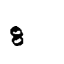

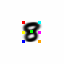

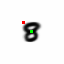

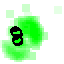

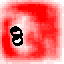

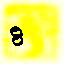

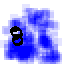

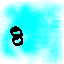

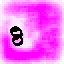

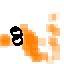

-------prnmg2+tra2-gauss--------	


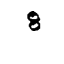

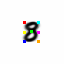

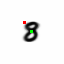

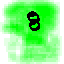

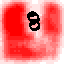

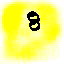

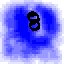

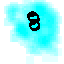

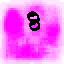

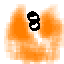

-------prnmg2+tra3-gauss--------	


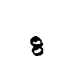

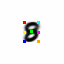

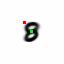

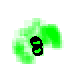

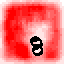

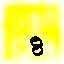

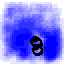

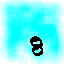

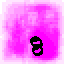

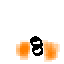

In [7]:
local inds = {30}

local nets = {'unet', 'pnmg', 'prnmg'}
local tasks = {'tra-gauss'}
local template = '../checkpoint/mnist-saliency/TASK/NET/testOutput.h5'

for _, net in ipairs(nets) do
    for _, task in ipairs(tasks) do
        local f = template:gsub('TASK', task):gsub('NET', net)
        db = hdf5.open(f, 'r')
        print('-------'..net.. '+'..task..'--------')

        for _, ind in ipairs(inds) do
            local id = string.format('id%05d', ind)
            local inputs = db:read(id..'/input'):all()
            local points = db:read(id..'/points'):all()
            local outputs = db:read(id..'/output'):all()
            local sals = db:read(id..'/saliency'):all()

            -- normalize sals
            local maxSals = sals:max(4):max(3):expandAs(sals)
            sals:cdiv(maxSals+1e-12)

            local input = inverse(inputs[1]*0.2746 + 0.1141)
            local output = inverse(outputs[1])
            local drawedOutput = drawPoints(output, points)

            itorch.image(input)
            itorch.image(drawedOutput)
            -- select yellow and blue points
            local gb = torch.Tensor({0,0,1,1,1,1,1}):byte():view(7,1,1,1):expandAs(points)
            points:maskedFill(gb, 0)
            itorch.image(drawPoints(output, points))

            local colorSals = drawSaliency(input:ge(0.5):float(), quantize(sals, 10))
            for i = 1,colorSals:size(1) do
                itorch.image(colorSals[i])
            end
        end

        db:close()
    end
end